# Imports

In [21]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define variables and path to model weights and configuration

In [22]:
IMAGE_SIZE = 320
CONFIDENCE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.3
CLASSES_FILE = 'coco_classes/coco.names'
CONFIG_FILE = 'weights-cfg/yolov3.cfg'
WEIGHTS_FILE = 'weights-cfg/yolov3.weights'

# Print the class names and it's length

In [23]:
with open(CLASSES_FILE, 'rt') as file:
    class_names = file.read().strip().split('\n')
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# Load the yolo model from darknet

In [24]:
network = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Function to find objects in the image

In [25]:
def detect_objects(predictions, image):
    height, width, _ = image.shape
    bounding_boxes, class_ids, confidences = [], [], []

    for prediction in predictions:
        for detection in prediction:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > CONFIDENCE_THRESHOLD:
                box_width, box_height = int(detection[2] * width), int(detection[3] * height)
                x, y = int((detection[0] * width) - box_width / 2), int((detection[1] * height) - box_height / 2)
                bounding_boxes.append([x, y, box_width, box_height])
                class_ids.append(class_id)
                confidences.append(float(confidence))

    indices = cv2.dnn.NMSBoxes(bounding_boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    
    for index in indices.flatten():
        x, y, box_width, box_height = bounding_boxes[index]
        cv2.rectangle(image, (x, y), (x + box_width, y + box_height), (255, 0, 255), 2)
        cv2.putText(image, f'{class_names[class_ids[index]].upper()} {int(confidences[index] * 100)}%', 
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

# Function to display images

In [26]:
def show_images(original, detected):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(detected, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Detected Image')
    axes[1].axis('off')
    
    plt.show()

# Function to detect classes from image and save it to a new directory

In [27]:
def process_images(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)

    for file_name in os.listdir(input_directory):
        if file_name.lower().endswith(('.jpg', '.png')):
            input_path = os.path.join(input_directory, file_name)
            image = cv2.imread(input_path)
            blob = cv2.dnn.blobFromImage(image, 1/255, (IMAGE_SIZE, IMAGE_SIZE), [0, 0, 0], crop=False)
            network.setInput(blob)

            output_layers = network.getUnconnectedOutLayersNames()
            predictions = network.forward(output_layers)

            # Process and save the image
            detected_image = image.copy()
            detect_objects(predictions, detected_image)
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, detected_image)
            print(f"Saved detected image to {output_path}")

            # Display original and detected images side by side
            show_images(image, detected_image)

# Path to directories

Saved detected image to images/result\dog.jpg


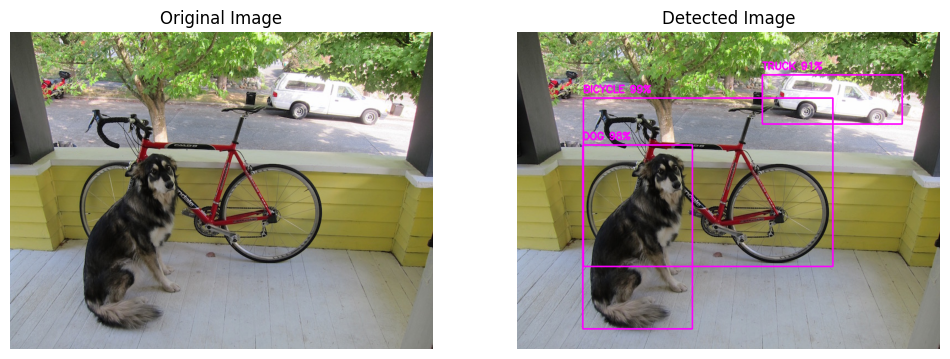

Saved detected image to images/result\eagle.jpg


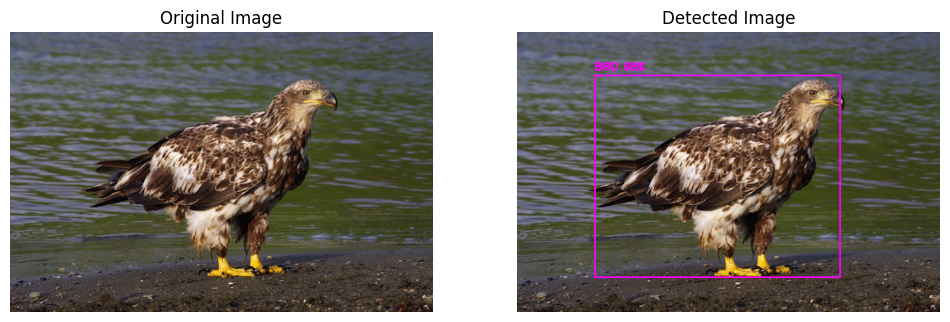

Saved detected image to images/result\giraffe.jpg


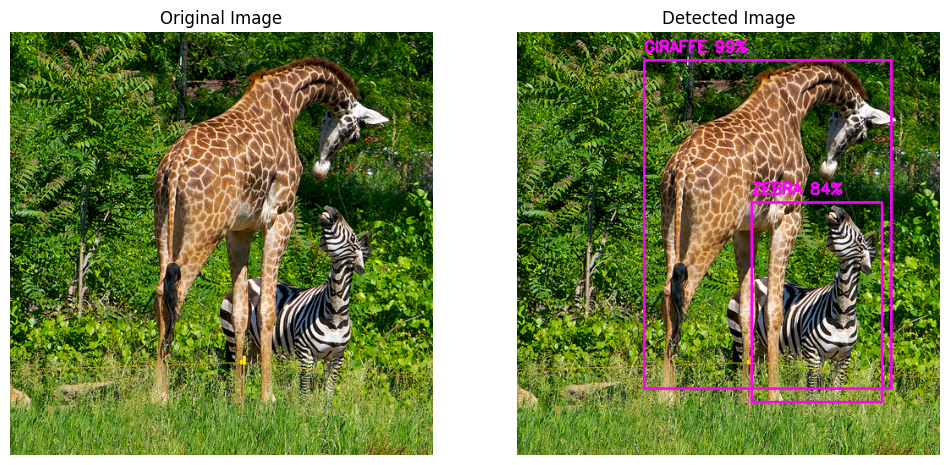

Saved detected image to images/result\horses.jpg


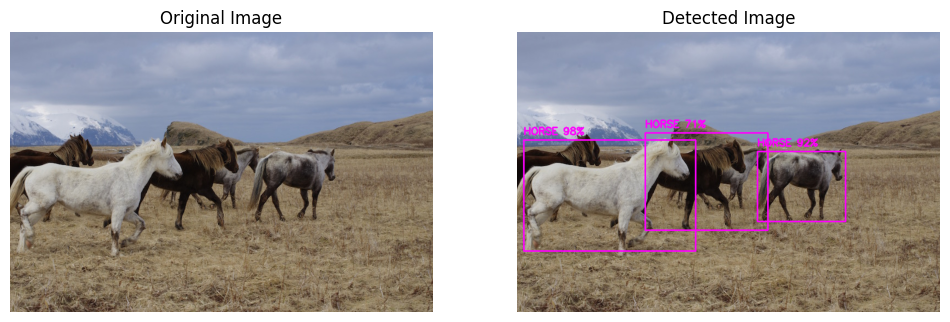

Saved detected image to images/result\person.jpg


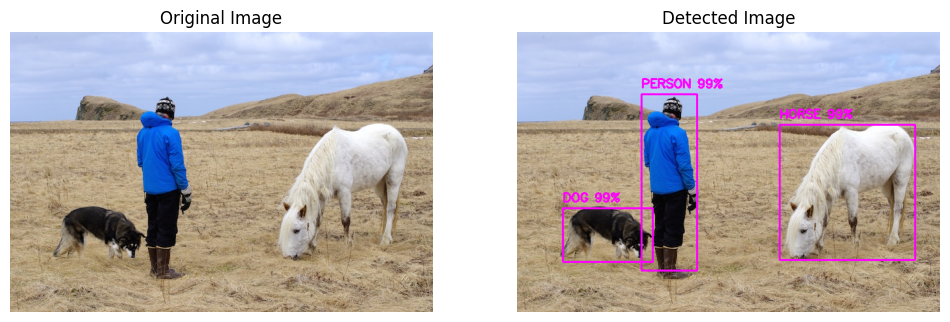

In [28]:
input_directory = 'images/test'
output_directory = 'images/result'
process_images(input_directory, output_directory)